In [255]:
import torch
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tabulate import tabulate
from tqdm import tqdm
from collections import OrderedDict
import pandas as pd

In [2]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

PyTorch version: 2.2.2
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver**********
CUDNN version: 8801

Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Available GPU devices: 1
Device Name: NVIDIA GeForce GTX 1650 Ti


device(type='cuda')

### Сбор датасета для дальнейшей валидации

In [1009]:
# Пути данных !!Заменить на only_tubulitis
#DATA_DIR = "C:\\Users\\minik\\Desktop\\datasets\\dataset_tubulitis"
TRAIN_DATA = "C:\\Users\\minik\\Desktop\\datasets\\only_tubulitis\\only_tubulitis\\train"
VAL_DATA = "C:\\Users\\minik\\Desktop\\datasets\\only_tubulitis\\only_tubulitis\\val"
TEST_DATA = "C:\\Users\\minik\\Desktop\\final\\TEST_KASKAD_THRESHOLD\\"
TRAIN_DATA_AUG = "C:\\Users\\minik\\Desktop\\datasets\\only_tubulitis\\only_tubulitis\\train_aug"

# Создаем датасеты для обучения
from torch.utils.data import ConcatDataset


transform_set = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
            ])

#Создаем класс для создания датасета, в котором используем аугментацию
#данных с помощью библиотеки Albumentation
class CustomDataset(Dataset):
    def __init__(self, img_path, msk_path, transform_set = transform_set):
        self.images_paths = os.path.join(img_path, 'images')
        self.masks_paths = os.path.join(msk_path, 'masks')
        self.image_filenames = sorted(list(set(os.listdir(self.images_paths)) - {'desktop.ini'}))
        self.transform_set = transform_set


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.images_paths, image_name)
        mask_path = os.path.join(self.masks_paths, image_name)

        #image = Image.open(image_path).convert("RGB")
        image = image_path
        mask = cv2.imread(mask_path, 0)
        #mask = cv2.resize(mask, (256,256))
        mask = np.where(mask<254, 1,0)
        # Normalize images and masks
        if self.transform_set:
            image = self.transform_set(image)
            mask = transforms.ToTensor()(mask)

        return image, mask
    
    

original_train_dataset = CustomDataset(
    img_path=TRAIN_DATA,
    msk_path=TRAIN_DATA,
    transform_set=transform_set
)

#Здесь мы используем обычную функцию, чтобы перевести изображение в тензоры
#и нормализровать его
augmentation_train_dataset = CustomDataset(
    img_path = TRAIN_DATA_AUG,
    msk_path = TRAIN_DATA_AUG,
    transform_set=transform_set
)

#Формируем окончательный тренировочный датасет
train_dataset = ConcatDataset(
    [original_train_dataset, augmentation_train_dataset]
)


val_dataset = CustomDataset(
    img_path=VAL_DATA,
    msk_path=VAL_DATA,
    transform_set=transform_set
)
test_dataset = CustomDataset(
    img_path=TEST_DATA,
    msk_path=TEST_DATA,
    transform_set = None
)


In [1008]:
test_dataset[3][1]

'C:\\Users\\minik\\Desktop\\final\\TEST_KASKAD_THRESHOLD\\images\\test1000.png'

In [998]:
np.unique(test_dataset[1][1])

array([0, 1])

In [999]:
type(test_dataset[0][1])

numpy.ndarray

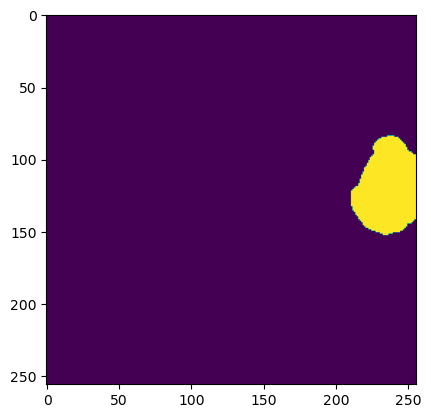

In [1000]:
plt.imshow(test_dataset[1][1])

In [939]:
# Создаем генераторы изображений для последовательной подачи в модель
# для тренировки, чтобы избежать ошибок с оперативной памятью и улучшить
# скорость обучения

train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)


val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False)


test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False)



### Import SMP, PTL, YOLO, Roboflow

In [903]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from roboflow import Roboflow
import supervision as sv
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

### Load Model

In [904]:
# Загрузка модели для сегментации тубулита
#model_tubules = YOLO("C:\\Users\\minik\\Desktop\\Project\\YOLO\\200_epochs-10\\weights\\best.pt")
rf = Roboflow(api_key="JAlc3jBAICvZVUpXXj7B")
project = rf.workspace().project("tubules-rhsfc")
model_tubules = project.version(1).model


loading Roboflow workspace...
loading Roboflow project...


In [905]:
model_tubules

In [23]:
# Загрузка модели для детекции MNL

rf = Roboflow(api_key="JAlc3jBAICvZVUpXXj7B")
project_MNL = rf.workspace().project("mnl")
model_MNL = project_MNL.version(1).model

loading Roboflow workspace...
loading Roboflow project...


### Inference on ONE image

In [995]:
test_dataset[0][0]

'C:\\Users\\minik\\Desktop\\final\\TEST_KASKAD_THRESHOLD\\images\\test1.png'

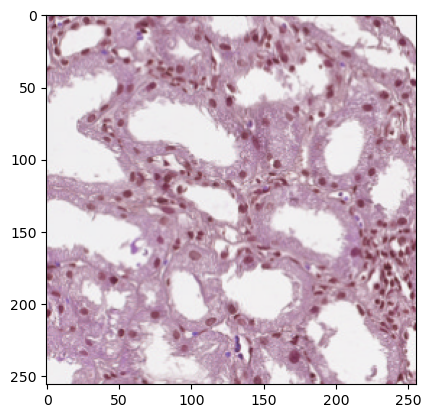

In [1044]:

image_path = ("C:\\Users\\minik\\Desktop\\final\\TEST_KASKAD_THRESHOLD\\images\\test10.png")

image = cv2.imread(image_path)
plt.imshow(image)

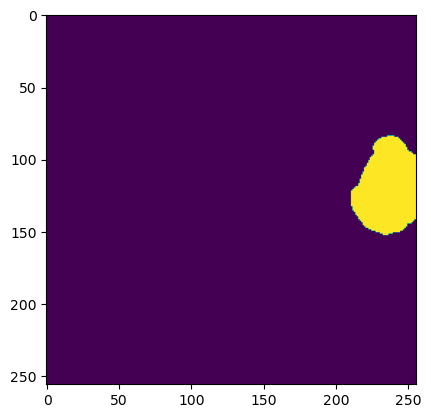

In [1045]:
mask_path = ("C:\\Users\\minik\\Desktop\\final\\TEST_KASKAD_THRESHOLD\\masks\\test10.png")
mask = cv2.imread(mask_path, 0)
mask = np.where(mask< 254, 1, 0)
plt.imshow(mask)

{'predictions': [{'x': 98.0, 'y': 234.5, 'width': 72.0, 'height': 43.0, 'confidence': 0.5845255851745605, 'class': 'Tubulitis', 'points': [{'x': 66.8, 'y': 213.60000000000002}, {'x': 66.0, 'y': 214.4}, {'x': 66.0, 'y': 214.8}, {'x': 65.2, 'y': 215.60000000000002}, {'x': 65.2, 'y': 216.0}, {'x': 64.4, 'y': 216.8}, {'x': 64.4, 'y': 217.20000000000002}, {'x': 63.6, 'y': 218.0}, {'x': 63.6, 'y': 218.4}, {'x': 62.800000000000004, 'y': 219.20000000000002}, {'x': 62.800000000000004, 'y': 219.60000000000002}, {'x': 62.400000000000006, 'y': 220.0}, {'x': 62.400000000000006, 'y': 233.60000000000002}, {'x': 62.800000000000004, 'y': 234.0}, {'x': 62.800000000000004, 'y': 234.8}, {'x': 63.2, 'y': 235.20000000000002}, {'x': 63.2, 'y': 236.8}, {'x': 63.6, 'y': 237.20000000000002}, {'x': 63.6, 'y': 238.8}, {'x': 64.0, 'y': 239.20000000000002}, {'x': 64.0, 'y': 240.0}, {'x': 64.4, 'y': 240.4}, {'x': 64.4, 'y': 240.8}, {'x': 64.8, 'y': 241.20000000000002}, {'x': 64.8, 'y': 242.0}, {'x': 65.2, 'y': 242.4

SupervisionWarnings: from_roboflow is deprecated: `Detections.from_roboflow` is deprecated and will be removed in `supervision-0.22.0`. Use `Detections.from_inference` instead.


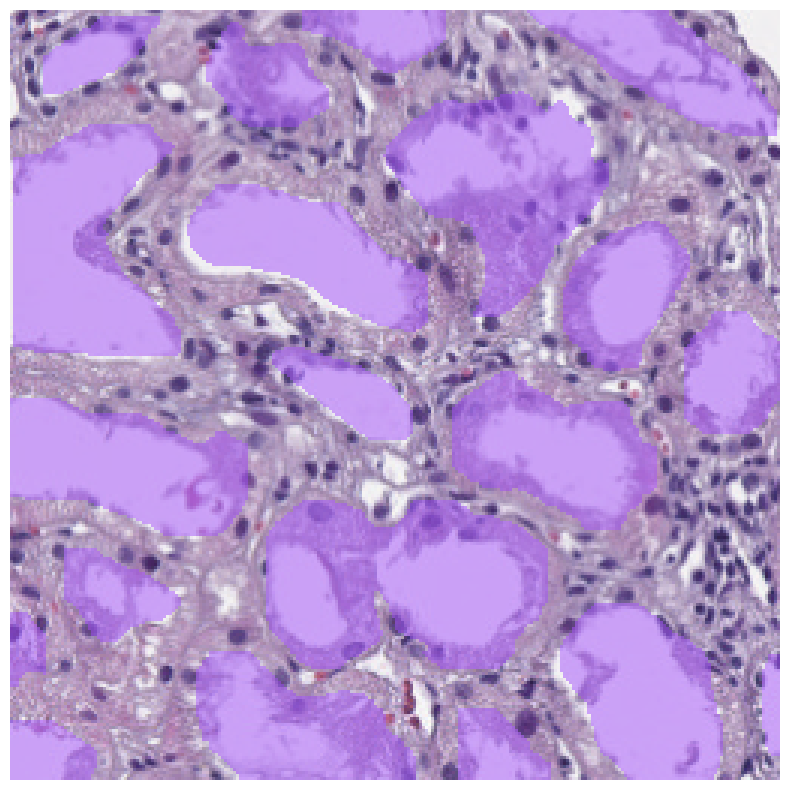

In [1046]:
import supervision as sv
result = model_tubules.predict(image_path=image_path, confidence=0.01).json()
print(result)
detections = sv.Detections.from_roboflow(result)
labels = [item["class"] for item in result["predictions"]]

mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()
bounding_box_annotator = sv.BoxAnnotator()

annotated_image = mask_annotator.annotate(
    scene=image, detections=detections)
#annotated_image = label_annotator.annotate(
#    scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(10, 10))


In [1047]:
len(result['predictions'])

21

### Отрисовска бинарной маски

In [1048]:
polygon_coords = [] 
for i in range(len(result['predictions']) - 1):
    polygon = []
    annot = result['predictions'][i]['points']
    for point in annot:
        polygon.append((point['x'], point['y']))
    polygon_coords.append(polygon)
    #polygon_coords = [(point['x'], point['y']) for point in annot]

#polygon_coords

In [1049]:
def create_binary_mask(polygon_coords, image_shape):
    # Создание пустой матрицы для бинарной маски
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    # Преобразование координат полигона в формат, подходящий для функции fillPoly
    polygon_coords = np.array([polygon_coords], dtype=np.int32)
    
    # Заполнение полигона в бинарной маске
    cv2.fillPoly(mask, polygon_coords, 1)
    
    return mask

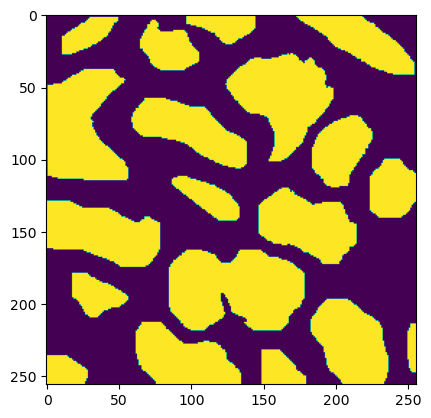

In [1050]:
# Размер изображения
image_shape = image.shape
image_shape = image_shape[:2]

# Создание пустой общей бинарной маски
combined_binary_mask = np.zeros(image_shape[:2], dtype=np.uint8)

# Создание бинарной маски для каждого объекта и объединение их в одну общую маску
for i in polygon_coords:
    object_binary_mask = create_binary_mask(i, image_shape)
    combined_binary_mask = cv2.bitwise_or(combined_binary_mask, object_binary_mask)
plt.imshow(combined_binary_mask)


### MNL_model_visual

{'predictions': [{'x': 98.5, 'y': 110.5, 'width': 3.0, 'height': 3.0, 'confidence': 0.4862860143184662, 'class': 'MNL', 'class_id': 0, 'detection_id': '1ada462d-a826-49a0-971d-c94c88b22a0d', 'image_path': 'C:\\Users\\minik\\Desktop\\final\\TEST_KASKAD_THRESHOLD\\images\\test10.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 155.5, 'y': 110.5, 'width': 3.0, 'height': 3.0, 'confidence': 0.3853464424610138, 'class': 'MNL', 'class_id': 0, 'detection_id': '24cdd40c-7f09-4bf8-b758-9c62faf5e3fe', 'image_path': 'C:\\Users\\minik\\Desktop\\final\\TEST_KASKAD_THRESHOLD\\images\\test10.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 212.5, 'y': 120.5, 'width': 3.0, 'height': 3.0, 'confidence': 0.32636433839797974, 'class': 'MNL', 'class_id': 0, 'detection_id': '9ebbd03b-51f6-48d9-a5a7-dc73bde874d5', 'image_path': 'C:\\Users\\minik\\Desktop\\final\\TEST_KASKAD_THRESHOLD\\images\\test10.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 238.5, 'y': 81.5, 'width': 3.0, 'height':

SupervisionWarnings: from_roboflow is deprecated: `Detections.from_roboflow` is deprecated and will be removed in `supervision-0.22.0`. Use `Detections.from_inference` instead.


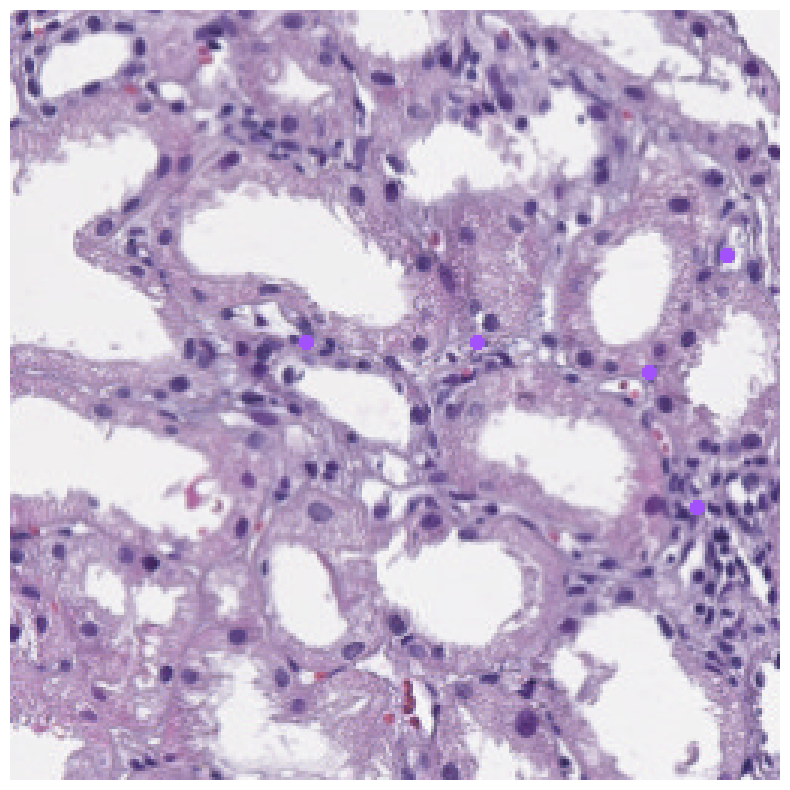

In [1074]:
import cv2
result_MNL = model_MNL.predict(image_path=image_path, confidence=0.3).json()
print(result_MNL)
labels_MNL = [item["class"] for item in result_MNL["predictions"]]

detections_MNL = sv.Detections.from_roboflow(result_MNL)
print(detections_MNL)
label_annotator_MNL = sv.LabelAnnotator()
mask_annotator = sv.MaskAnnotator()
bounding_box_annotator_MNL = sv.CircleAnnotator()
image = cv2.imread(image_path)

annotated_image_MNL = bounding_box_annotator_MNL.annotate(
    scene=image, detections=detections_MNL)
#annotated_image_MNL = label_annotator.annotate(
#    scene=annotated_image_MNL, detections=detections_MNL, labels=labels_MNL)

sv.plot_image(image=annotated_image_MNL, size=(10, 10))

### Поиск пересечений - функция пересечения

In [1075]:
import shapely
from shapely.geometry import Polygon

def bbox_to_polygon(bbox):
    """
    Преобразует координаты bbox в формат полигона.
    Возвращает список координат полигона [(x1, y1), (x2, y2), ..., (x1, y1)].
    """
    x_min, y_min, x_max, y_max = bbox
    polygon = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max), (x_min, y_min)]
    return polygon

bbox_list

[(98.5, 110.5, 101.5, 113.5),
 (155.5, 110.5, 158.5, 113.5),
 (212.5, 120.5, 215.5, 123.5),
 (238.5, 81.5, 241.5, 84.5),
 (228.5, 165.0, 231.5, 167.0),
 (111.5, 17.5, 114.5, 20.5),
 (244.5, 61.5, 247.5, 64.5),
 (242.5, 183.5, 245.5, 186.5),
 (131.5, 208.5, 134.5, 211.5),
 (95.5, 52.5, 98.5, 55.5),
 (252.0, 178.5, 254.0, 181.5),
 (232.5, 218.5, 235.5, 221.5),
 (251.5, 249.0, 254.5, 251.0),
 (232.5, 200.5, 235.5, 203.5),
 (83.5, 185.5, 86.5, 188.5),
 (5.5, 8.0, 8.5, 12.0),
 (248.5, 222.5, 251.5, 225.5),
 (171.5, 170.5, 174.5, 173.5),
 (187.5, 192.5, 190.5, 195.5),
 (244.5, 150.0, 247.5, 152.0),
 (203.0, 124.5, 207.0, 127.5),
 (251.5, 187.5, 254.5, 190.5),
 (87.5, 48.5, 90.5, 51.5),
 (255.0, 215.5, 257.0, 218.5),
 (188.5, 180.5, 191.5, 183.5),
 (238.5, 155.5, 241.5, 158.5),
 (141.5, 232.5, 144.5, 235.5),
 (151.5, 121.5, 154.5, 124.5),
 (238.5, 186.0, 241.5, 188.0),
 (84.5, 40.5, 87.5, 43.5),
 (173.5, 223.5, 176.5, 226.5),
 (41.5, 73.5, 44.5, 76.5),
 (219.5, 182.5, 222.5, 185.5),
 (66.5, 1

Bounding box: [(98.5, 110.5, 101.5, 113.5), (155.5, 110.5, 158.5, 113.5), (212.5, 120.5, 215.5, 123.5), (238.5, 81.5, 241.5, 84.5)]
4
[[(98.5, 110.5), (101.5, 110.5), (101.5, 113.5), (98.5, 113.5), (98.5, 110.5)], [(155.5, 110.5), (158.5, 110.5), (158.5, 113.5), (155.5, 113.5), (155.5, 110.5)], [(212.5, 120.5), (215.5, 120.5), (215.5, 123.5), (212.5, 123.5), (212.5, 120.5)]]


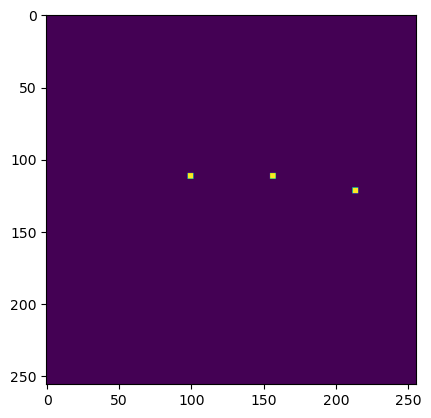

In [1076]:
# Функция для преобразования предсказания в bbox формата (x_min, y_min, x_max, y_max)
def prediction_to_bbox(prediction):
    x_min = prediction['x']
    y_min = prediction['y']
    x_max = x_min + prediction['width']
    y_max = y_min + prediction['height']
    return x_min, y_min, x_max, y_max



bbox_list = [] 
for i in range(len(result_MNL['predictions']) - 1):
    bbox = prediction_to_bbox(result_MNL['predictions'][i])
    bbox_list.append(bbox)

print("Bounding box:", bbox_list)
print(len(bbox_list))

bbox_poly = [] 
for i in range(len(bbox_list)-1):
    #polygon = []
    annot_bbox = bbox_list[i]
    poly = bbox_to_polygon(annot_bbox)

    bbox_poly.append(poly)

print(bbox_poly)

# Создание пустой общей бинарной маски
combined_binary_mask_MNL = np.zeros(image_shape[:2], dtype=np.uint8)

# Создание бинарной маски для каждого объекта и объединение их в одну общую маску
for i in bbox_poly:
    object_binary_mask = create_binary_mask(i, image_shape)
    combined_binary_mask_MNL = cv2.bitwise_or(combined_binary_mask_MNL, object_binary_mask)
plt.imshow(combined_binary_mask_MNL)

In [1077]:
def check_intersection(poly1, poly2):
    """
    Проверяет пересечение между двумя полигонами.
    Возвращает True, если есть пересечение, и False в противном случае.
    """
    poly2 = bbox_to_polygon(poly2)
    polygon1 = Polygon(poly1)
    #print(polygon1)
    polygon2 = Polygon(poly2)
    #intersect = polygon1.intersection(polygon2).area
    #union = polygon1.union(polygon2).area
    #iou = intersect / union
    #if iou>0:
    #    print(iou)
    return Polygon.intersects(polygon1, polygon2)

In [1078]:
intersecting_polygons = []
for i in polygon_coords:
    for bbox_coords in bbox_list:
       # print(bbox_coords)
        if check_intersection(i, bbox_coords):
            # Добавляем этот полигон в список
            intersecting_polygons.append(i)
            
intersecting_polygons

[[(93.60000000000001, 112.0),
  (93.2, 112.4),
  (92.80000000000001, 112.4),
  (92.4, 112.80000000000001),
  (91.60000000000001, 112.80000000000001),
  (91.2, 113.2),
  (90.0, 113.2),
  (89.60000000000001, 113.60000000000001),
  (88.80000000000001, 113.60000000000001),
  (88.0, 114.4),
  (87.60000000000001, 114.4),
  (87.60000000000001, 114.80000000000001),
  (87.2, 115.2),
  (87.2, 116.80000000000001),
  (87.60000000000001, 117.2),
  (87.60000000000001, 117.60000000000001),
  (89.60000000000001, 119.60000000000001),
  (90.0, 119.60000000000001),
  (90.80000000000001, 120.4),
  (91.2, 120.4),
  (93.60000000000001, 122.80000000000001),
  (94.0, 122.80000000000001),
  (94.4, 123.2),
  (94.80000000000001, 123.2),
  (95.60000000000001, 124.0),
  (96.0, 124.0),
  (96.80000000000001, 124.80000000000001),
  (97.2, 124.80000000000001),
  (98.4, 126.0),
  (98.80000000000001, 126.0),
  (102.4, 129.6),
  (102.80000000000001, 129.6),
  (104.80000000000001, 131.6),
  (105.2, 131.6),
  (106.4, 132.8

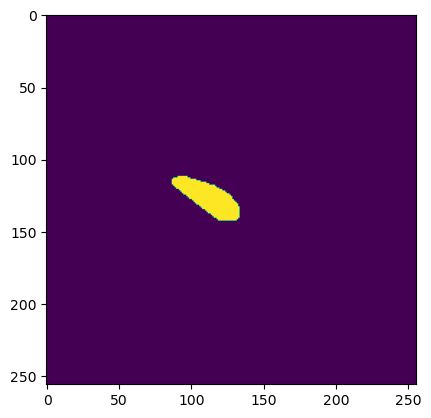

In [1079]:
# Создание пустой общей бинарной маски
combined_binary_mask = np.zeros(image_shape[:2], dtype=np.uint8)

# Создание бинарной маски для каждого объекта и объединение их в одну общую маску
for i in intersecting_polygons:
    object_binary_mask = create_binary_mask(i, image_shape)
    combined_binary_mask = cv2.bitwise_or(combined_binary_mask, object_binary_mask)
plt.imshow(combined_binary_mask)


In [1057]:
from shapely.errors import TopologicalError

In [1089]:
def annotation_to_polygon(annotation):
    """
    Преобразует аннотацию (предсказание) в формат полигона.
    """
    polygon = []
    points = annotation['points']
    for point in points:
        polygon.append((point['x'], point['y']))
    return polygon

def prediction_to_bbox(prediction):
    """
    Преобразует предсказание в формат bbox (x_min, y_min, x_max, y_max).
    """
    x_min = prediction['x']
    y_min = prediction['y']
    x_max = x_min + prediction['width']
    y_max = y_min + prediction['height']
    return x_min, y_min, x_max, y_max

def bbox_to_polygon(bbox):
    """
    Преобразует координаты bbox в формат полигона.
    """
    x_min, y_min, x_max, y_max = bbox
    polygon = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
    return polygon

def create_binary_mask(polygon_coords, image_shape):
    """
    Создает бинарную маску для указанных координат полигона.
    """
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    polygon_coords = np.array([polygon_coords], dtype=np.int32)
    cv2.fillPoly(mask, polygon_coords, 1)
    return mask

# Функция для исправления топологических ошибок
def safe_polygon(polygon_points):
    try:
        polygon = Polygon(polygon_points).buffer(0)
        if not polygon.is_valid:
            raise TopologicalError("Invalid Polygon")
        return polygon
    except TopologicalError:
        return Polygon([])  # Возвращает пустой полигон при ошибке
    
### Настройка Threshold & Distance для близко лежащих полигонов

### Настройка Threshold & Distance для близко лежащих полигонов
def find_intersecting_masks(segmentation_annotations, detection_predictions, image_shape, intersection_threshold=0.7, distance_threshold=5):
    """
    Находит пересекающиеся маски сегментации и bbox детекции MNL,
    подсчитывается количество MNL в маске канальца и добавляется в 
    лист (стадии тубулита во всех канальцах с пересечениями),
    плитке присваивается стадия тубулита согласно классификации:
    Если пересечений нет - t0,
    Если пересечений меньше 4 - t1,
    Если от 4 до 10 - t2,
    Если более 10 - t3
    return t: стадия тубулита
    """
    intersecting_masks = []
    list_of_number_lympho = []
    
    # Преобразование bbox детекции в полигоны
    detection_polygons = [safe_polygon(bbox_to_polygon(prediction_to_bbox(prediction))) for prediction in detection_predictions]

    # Преобразование аннотаций сегментации в полигоны и проверка пересечений
    for annotation in segmentation_annotations:
        lymphocytes_in_tubules = 0
        polygon = safe_polygon(annotation_to_polygon(annotation))

        for detection_polygon in detection_polygons:
            if polygon.intersects(detection_polygon):
                intersection_area = polygon.intersection(detection_polygon).area
                union_area = polygon.union(detection_polygon).area
                if intersection_area / union_area >= intersection_threshold:
                    intersecting_masks.append(annotation_to_polygon(annotation))
                    lymphocytes_in_tubules += 1
            elif polygon.distance(detection_polygon) <= distance_threshold:
                intersecting_masks.append(annotation_to_polygon(annotation))
                lymphocytes_in_tubules += 1
       
        list_of_number_lympho.append(lymphocytes_in_tubules)
    
    # Создание общей бинарной маски для пересекающихся масок
    combined_binary_mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for mask_coords in intersecting_masks:
        mask = create_binary_mask(mask_coords, image_shape)
        combined_binary_mask = cv2.bitwise_or(combined_binary_mask, mask)
    
    mean_lympho_in_tubules = np.mean(list_of_number_lympho)
    
    if mean_lympho_in_tubules == 0:
        t = 0
    elif mean_lympho_in_tubules < 4:
        t = 1
    elif 4 <= mean_lympho_in_tubules < 10:
        t = 2   
    else:
        t = 3
        
    return combined_binary_mask, t

# Пример использования функции
combined_mask = find_intersecting_masks(result['predictions'], result_MNL['predictions'], image.shape[:2])

In [1090]:
combined_mask


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 1)

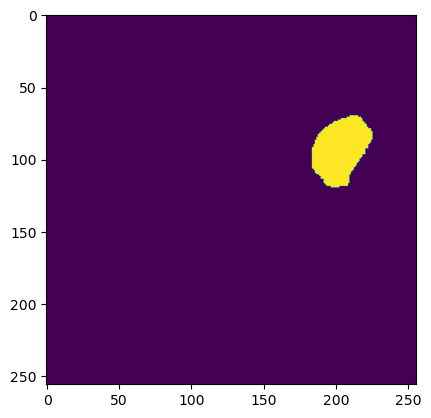

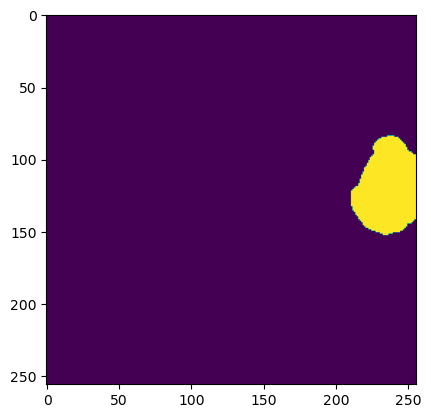

In [1091]:
plt.imshow(combined_mask[0])
plt.show()
plt.imshow(mask)

In [1092]:
image_path= ("C:\\Users\\minik\\Desktop\\TEST_VISUAL_OK\\t0\\masks\\Tubulitis")
for i in range(1, len(os.listdir("C:\\Users\\minik\\Desktop\\TEST_VISUAL_OK\\t0\\images"))):
    image_np = np.zeros((256,256),dtype=np.uint8)

    cv2.imwrite(
            os.path.join(image_path, f"test{i}.png"),
            cv2.cvtColor((image_np * 255).astype(np.uint8),
            cv2.COLOR_RGB2BGR))

In [90]:
np.unique(combined_mask[0])

array([0, 1], dtype=uint8)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, confusion_matrix
import sklearn
criterion = smp.losses.DiceLoss(mode='binary')
# Переменные для хранения суммарных значений метрик
# Переменные для хранения суммарных значений метрик
total_precision = 0
total_recall = 0
total_iou = 0
total_f1 = 0
total_count = 0

# Списки для хранения значений метрик для каждого изображения
precision_list = []
recall_list = []
iou_list = []
f1_list = []
conf_matrix_list = []

# Обработка изображений из тестового набора данных
for image_path, true_mask in test_dataset:
    # Предсказание масок
    result = model_tubules.predict(image_path=image_path, confidence=0.01).json()
    result_MNL = model_MNL.predict(image_path=image_path, confidence=0.3).json()
    combined_mask = find_intersecting_masks(result['predictions'], result_MNL['predictions'], (256, 256))
    predicted_mask = combined_mask[0]
    
    # Вычисление метрик
    precision = precision_score(true_mask.flatten(), predicted_mask.flatten(), average='binary')
    recall = recall_score(true_mask.flatten(), predicted_mask.flatten(), average='binary')
    iou = jaccard_score(true_mask.flatten(), predicted_mask.flatten(), average='binary')
    f1 = f1_score(true_mask.flatten(), predicted_mask.flatten(), average='binary')
    # Вывод для отладки
    print(f"Precision: {precision}, Recall: {recall}, IoU: {iou}, F1: {f1}")
    
    # Вычисление матрицы ошибок
    conf_matrix = confusion_matrix(true_mask.flatten(), predicted_mask.flatten())
    
    # Сохранение метрик в соответствующие списки
    precision_list.append(precision)
    recall_list.append(recall)
    iou_list.append(iou)
    f1_list.append(f1)
    conf_matrix_list.append(conf_matrix)
    
    # Добавление метрик к общим суммам для последующего вычисления средних значений
    total_precision += precision
    total_recall += recall
    total_iou += iou
    total_f1 += f1
    total_count += 1

# Вычисление средних значений метрик
average_precision = total_precision / total_count
average_recall = total_recall / total_count
average_iou = total_iou / total_count
average_f1 = total_f1 / total_count

# Вывод средних значений метрик
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average IoU:", average_iou)
print("Average F1 Score:", average_f1)

# Вывод значений метрик для каждого изображения
print("Precision for each image:", precision_list)
print("Recall for each image:", recall_list)
print("IoU for each image:", iou_list)
print("F1 Score for each image:", f1_list)
print("Confusion Matrix for each image:", conf_matrix_list)

### На валидационном датасете с определением t (тубулита)

In [214]:
def stage_tubulitis(segmentation_annotations, detection_predictions, image_shape):
    """
    Находит пересекающиеся маски сегментации и bbox детекции MNL,
    подсчитывается количество MNL в маске канальца и добавляется в 
    лист (стадии тубулита во всех канальцах с пересечениями),
    плитке присваивается стадия тубулита согласно классификации:
    Если пересечений нет - t0,
    Если пересечений меньше 4 - t1,
    Если от 4 до 10 - t2,
    Если более 10 - t3
    return t: стадия тубулита
    """
    intersecting_masks = []
    list_of_number_lympho = []
    
    # Преобразование bbox детекции в полигоны
    detection_polygons = [bbox_to_polygon(prediction_to_bbox(prediction)) for prediction in detection_predictions]

    # Преобразование аннотаций сегментации в полигоны и проверка пересечений
    for annotation in segmentation_annotations:
        
        lymphocytes_in_tubules = 0
        polygon = annotation_to_polygon(annotation)

        for detection_polygon in detection_polygons:
            if Polygon(polygon).intersects(Polygon(detection_polygon)):
                intersecting_masks.append(polygon)
                lymphocytes_in_tubules +=1
       
        list_of_number_lympho.append(lymphocytes_in_tubules)
        
    if len(list_of_number_lympho) == 0:
        t = 0
    else:    
        mean_lympho_in_tubules = np.max(list_of_number_lympho)

        if mean_lympho_in_tubules == 0:
            t = 0
        if 0<mean_lympho_in_tubules < 4:
            t = 1
        if 4 <= mean_lympho_in_tubules < 10:
            t = 2   
        if mean_lympho_in_tubules >= 10:
            t = 3

    return t

In [869]:
### Настройка Threshold & Distance для близко лежащих полигонов

def stage_tubulitis_threshold(segmentation_annotations, detection_predictions, image_shape, intersection_threshold=0.5, distance_threshold=10):
    """
    Находит пересекающиеся маски сегментации и bbox детекции MNL,
    подсчитывается количество MNL в маске канальца и добавляется в 
    лист (стадии тубулита во всех канальцах с пересечениями),
    плитке присваивается стадия тубулита согласно классификации:
    Если пересечений нет - t0,
    Если пересечений меньше 4 - t1,
    Если от 4 до 10 - t2,
    Если более 10 - t3
    return t: стадия тубулита
    """
    intersecting_masks = []
    list_of_number_lympho = []
    
    # Преобразование bbox детекции в полигоны
    detection_polygons = [bbox_to_polygon(prediction_to_bbox(prediction)) for prediction in detection_predictions]

    # Преобразование аннотаций сегментации в полигоны и проверка пересечений
    for annotation in segmentation_annotations:
        
        lymphocytes_in_tubules = 0
        polygon = Polygon(annotation_to_polygon(annotation))

        for detection_polygon in detection_polygons:
            detection_poly = Polygon(detection_polygon)
            if polygon.intersects(detection_poly):
                intersection_area = polygon.intersection(detection_poly).area
                union_area = polygon.union(detection_poly).area
                if intersection_area / union_area >= intersection_threshold:
                    intersecting_masks.append(polygon)
                    lymphocytes_in_tubules += 1
            elif polygon.distance(detection_poly) <= distance_threshold:
                intersecting_masks.append(polygon)
                lymphocytes_in_tubules += 1
       
        list_of_number_lympho.append(lymphocytes_in_tubules)
        
    if len(list_of_number_lympho) == 0:
        t = 0
    else:    
        max_lympho_in_tubules = np.max(list_of_number_lympho)

        if max_lympho_in_tubules == 0:
            t = 0
        elif 0 < max_lympho_in_tubules < 4:
            t = 1
        elif 4 <= max_lympho_in_tubules < 10:
            t = 2   
        elif max_lympho_in_tubules >= 10:
            t = 3

    return t

In [ ]:
#list_predict = pd.DataFrame(columns=['Name_Image', 't_predict'])
#list_predict

In [870]:
import glob
test_images = []
name_image = '1002823 - 0'
for directory_path in sorted(glob.glob('C:\\Users\\minik\\Desktop\\final\\test_ds\\tiles')):
    for img_path in sorted(glob.glob(os.path.join(directory_path, name_image,"*.png"))):
        #img = cv2.imread(img_path, 1)
        #img = A.Normalize(img)
        test_images.append(img_path)

In [871]:
t_wsi = []
for image in test_images:
    # Пример использования функции
    result = model_tubules.predict(image_path=image, confidence=0.01).json()
    result_MNL = model_MNL.predict(image_path=image, confidence=0.45).json()
    t_tile = stage_tubulitis(result['predictions'], result_MNL['predictions'], (256,256))
    print(t_tile)
    t_wsi.append(t_tile)
t_wsi = np.mean(t_wsi)
print(f'For image {name_image}: {t_wsi}')

1
1
0
1
1
1
1
1
1
0


KeyboardInterrupt: 

In [637]:
predict = pd.DataFrame({
    'Name_Image': [name_image],
    't_predict': [t_wsi]
})
predict

,Name_Image,t_predict
0,1002823 - 0,0.575


In [638]:
list_predict = pd.concat([list_predict, predict])

In [639]:
list_predict

,Name_Image,t_predict
0,1002790 - 0,0.366972
0,1002788 - 2,1.054795
0,1002791 - менее 1,0.571429
0,1002792 - менее 1,0.308411
0,1002793 - менее 1,0.503937
0,1002795 - 1,0.344828
0,1002796 - 0,0.085106
0,1002797 - менее 1,0.329114
0,1002798 - 1,0.173333
0,1002800 - 2,0.944444


In [640]:
df = list_predict.copy()

In [641]:
print(df.head())
print(len(df))

          Name_Image  t_predict
0        1002790 - 0   0.366972
0        1002788 - 2   1.054795
0  1002791 - менее 1   0.571429
0  1002792 - менее 1   0.308411
0  1002793 - менее 1   0.503937
45


In [642]:
df['Name_Image'] = df['Name_Image'].str.replace('менее','<')

In [643]:
df[['Name_Image','Grade_Patolog']] = df['Name_Image'].str.split('-', expand=True)

In [717]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name_Image          43 non-null     int64  
 1   t_predict           43 non-null     float64
 2   Grade_Patolog       43 non-null     int64  
 3   Grade_roundPredcit  43 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 1.5 KB


### LogisticRegression

In [ ]:
#df.to_csv("C:\\Users\\minik\\Desktop\\df_final_1.csv", sep=';')

In [ ]:
df = pd.read_csv("C:\\Users\\minik\\Desktop\\df_final.csv", sep=';')

In [1097]:
df

,Name_Image,t_predict,Grade_Patolog,Grade_roundPredcit
0,1002790,0.366972,0,1
1,1002788,1.054795,2,2
2,1002791,0.571429,1,1
3,1002792,0.308411,1,1
4,1002793,0.503937,1,1
5,1002795,0.344828,1,1
6,1002796,0.085106,0,0
7,1002797,0.329114,1,1
8,1002798,0.173333,1,0
9,1002800,0.944444,2,2


In [750]:
#LogisticRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


In [850]:
# For t0/t1
df_0_1 = df[df['Grade_Patolog']<2]
X = df_0_1[['t_predict']]
y = df_0_1['Grade_Patolog']

In [851]:
len(df_0_1)

37

In [852]:
# Стратифицированное разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [853]:
# Проверка распределения классов в обучающей и тестовой выборках
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

Train class distribution:
 Grade_Patolog
1    14
0    11
Name: count, dtype: int64
Test class distribution:
 Grade_Patolog
1    6
0    6
Name: count, dtype: int64


In [854]:
model = LogisticRegression() #multi_class='multinomial'
model.fit(X_train, y_train)

LogisticRegression()

In [855]:
# Предсказание на тестовой выборке
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

Accuracy: 0.8333333333333334
Confusion Matrix:
 [[4 2]
 [0 6]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.75      1.00      0.86         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12



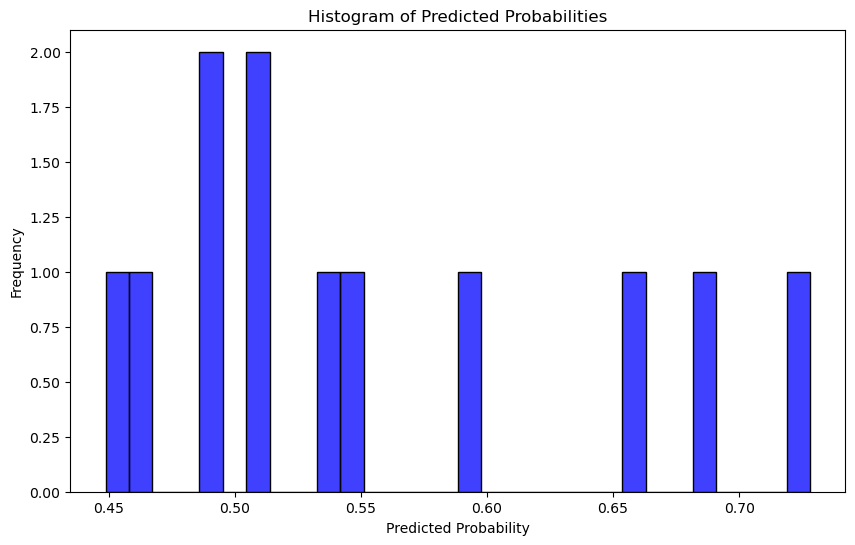

In [856]:
# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Построение графика вероятностей
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_prob, kde=False, bins=30, color='blue')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [857]:
# Вывод коэффициентов модели
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Расчет точки, где вероятность класса 1 равна 0.5
t_predict_threshold = -intercept / coefficients[0]
print(f'Threshold t_predict where probability of class 1 is 0.5: {t_predict_threshold}')

Threshold t_predict where probability of class 1 is 0.5: 0.2764529668992082


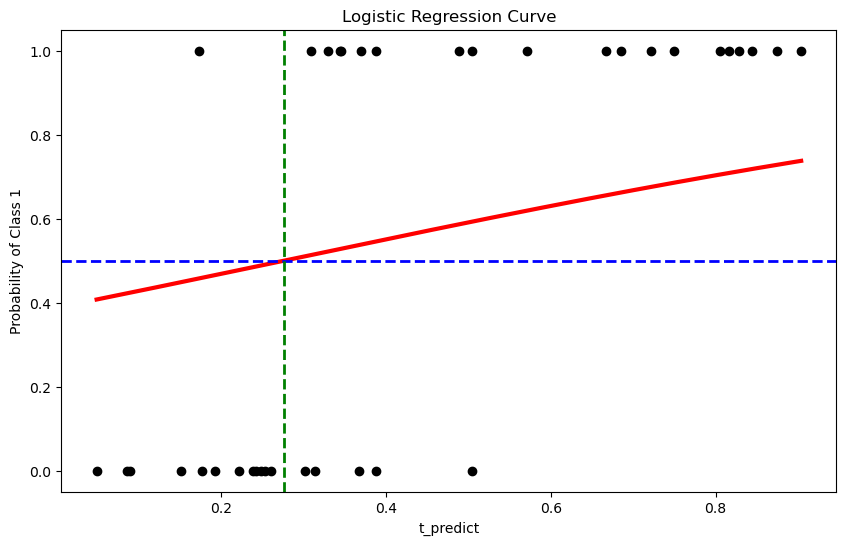

Threshold t_predict where probability of class 1 is 0.5: 0.2764529668992082


In [858]:
# Вычисление предсказанных вероятностей для значений t_predict
X_values = np.linspace(X.min(), X.max(), 300)
X_values = X_values.reshape(-1, 1)
y_proba = model.predict_proba(X_values)[:, 1]

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black')
plt.plot(X_values, y_proba, color='red', linewidth=3)

# Добавление пороговой линии
plt.axhline(0.5, color='blue', linestyle='--', linewidth=2)
plt.axvline(-intercept / coefficients[0], color='green', linestyle='--', linewidth=2)

# Настройка графика
plt.xlabel('t_predict')
plt.ylabel('Probability of Class 1')
plt.title('Logistic Regression Curve')
plt.show()

# Вывод коэффициентов модели
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Расчет точки, где вероятность класса 1 равна 0.5
t_predict_threshold = -intercept / coefficients[0]
print(f'Threshold t_predict where probability of class 1 is 0.5: {t_predict_threshold}')

Accuracy: 0.875
Confusion Matrix:
 [[6 0]
 [1 1]]
Classification Report:
               precision    recall  f1-score   support

           1       0.86      1.00      0.92         6
           2       1.00      0.50      0.67         2

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8



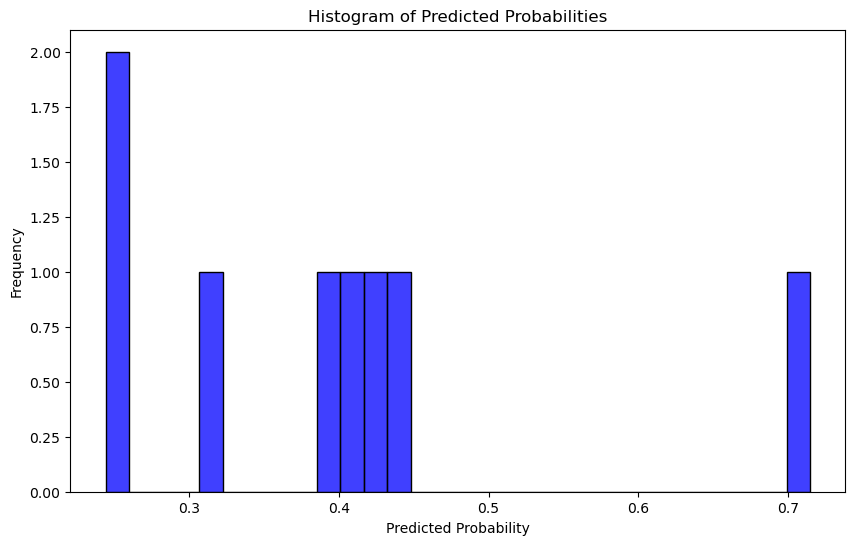

Threshold t_predict where probability of class 1 is 0.5: 0.8633288854706963


In [863]:
df_1_2 = df[df['Grade_Patolog']>0] # Для нахождения thresholda между 1 и 2 классом.
X_2 = df_1_2[['t_predict']]
y_2 = df_1_2['Grade_Patolog']

# Стратифицированное разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, stratify=y_2)

# Определение минимального числа соседей
min_samples = min(y_train.value_counts())

# Применение SMOTE для увеличения количества примеров меньшего класса с учетом малого количества образцов
smote = SMOTE(random_state=42, k_neighbors=min(min_samples-1, 5))
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


model = LogisticRegression() #multi_class='multinomial'
model.fit(X_train_res, y_train_res)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Построение графика вероятностей
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_prob, kde=False, bins=30, color='blue')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


# Вывод коэффициентов модели
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Расчет точки, где вероятность класса 1 равна 0.5
t_predict_threshold = -intercept / coefficients[0]
print(f'Threshold t_predict where probability of class 1 is 0.5: {t_predict_threshold}')

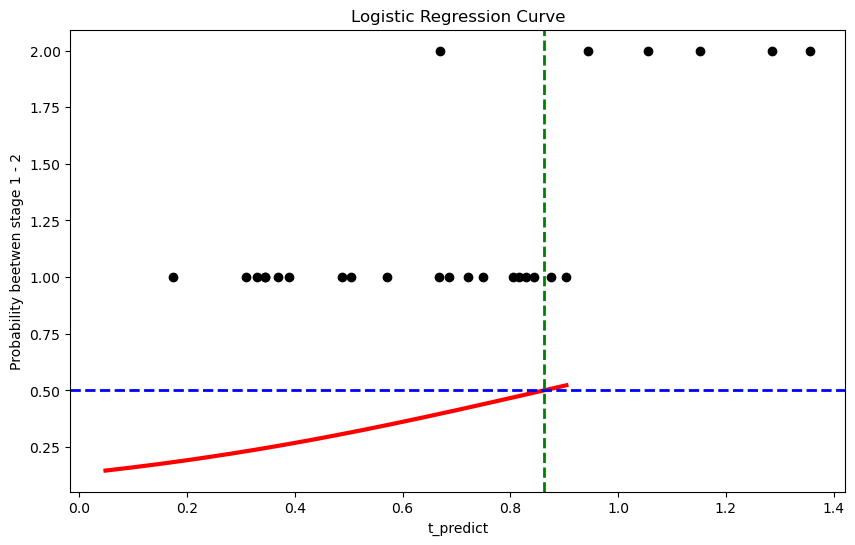

Threshold t_predict where probability of class 1 is 0.5: 0.8633288854706963


In [865]:
# Вычисление предсказанных вероятностей для значений t_predict
X_values = np.linspace(X.min(), X.max(), 300)
X_values = X_values.reshape(-1, 1)
y_proba = model.predict_proba(X_values)[:, 1]

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(X_2, y_2, color='black')
plt.plot(X_values, y_proba, color='red', linewidth=3)

# Добавление пороговой линии
plt.axhline(0.5, color='blue', linestyle='--', linewidth=2)
plt.axvline(-intercept / coefficients[0], color='green', linestyle='--', linewidth=2)

# Настройка графика
plt.xlabel('t_predict')
plt.ylabel('Probability beetwen stage 1 - 2')
plt.title('Logistic Regression Curve')
plt.show()

# Вывод коэффициентов модели
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Расчет точки, где вероятность класса 1 равна 0.5
t_predict_threshold = -intercept / coefficients[0]
print(f'Threshold t_predict where probability of class 1 is 0.5: {t_predict_threshold}')

### Создание функции для округления t_predict на основе данных логистической регресии

In [1175]:
def round_t_predict(t_predict):
    if t_predict < 0.29:
        Grade_roundPredcit = 0
    if 0.29 <= t_predict < 1:
        Grade_roundPredcit = 1
    if 1 <= t_predict:
        Grade_roundPredcit = 2

    return Grade_roundPredcit  

In [1176]:
df['Grade_roundPredcit'] = df['t_predict'].apply(round_t_predict)
df.head()

,Name_Image,t_predict,Grade_Patolog,Grade_roundPredcit
0,1002790,0.366972,0,1
1,1002788,1.054795,2,2
2,1002791,0.571429,1,1
3,1002792,0.308411,1,1
4,1002793,0.503937,1,1


### Оценка по Каппа-Коэна

In [1177]:
df_1 = df.copy()

In [1161]:
#df_1['Grade_Patolog'] = df_1['Grade_Patolog'].str.replace('< 1','1').astype(int)

In [1178]:
df_1['Grade_Patolog'].value_counts()

Grade_Patolog
1    20
0    17
2     6
Name: count, dtype: int64

In [1179]:
from sklearn.metrics import cohen_kappa_score

# Вычисление коэффициента каппа Коэна
kappa = cohen_kappa_score(df_1['Grade_Patolog'], df_1['Grade_roundPredcit'])

print(f"Cohen's Kappa: {kappa}")

Cohen's Kappa: 0.6826568265682658


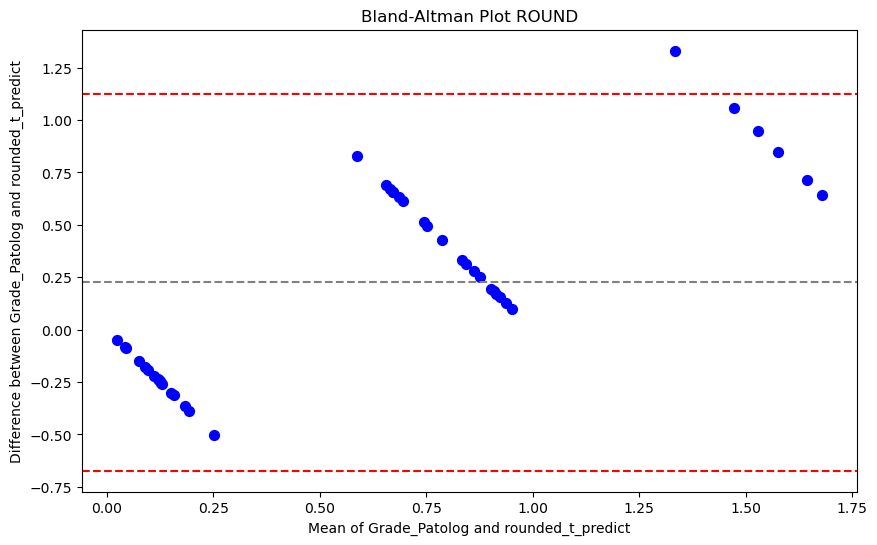

In [1164]:
# Рассчитаем средние и разности
df_1['mean'] = df_1[['Grade_Patolog', 't_predict']].mean(axis=1)
df_1['diff'] = df_1['Grade_Patolog'] - df_1['t_predict']

mean_diff = df_1['diff'].mean()
std_diff = df_1['diff'].std()

# Построение Bland-Altman Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_1['mean'], df_1['diff'], color='blue', s=50)
plt.axhline(mean_diff, color='gray', linestyle='--')
plt.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--')
plt.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--')

plt.title('Bland-Altman Plot ROUND')
plt.xlabel('Mean of Grade_Patolog and rounded_t_predict')
plt.ylabel('Difference between Grade_Patolog and rounded_t_predict')
plt.show()

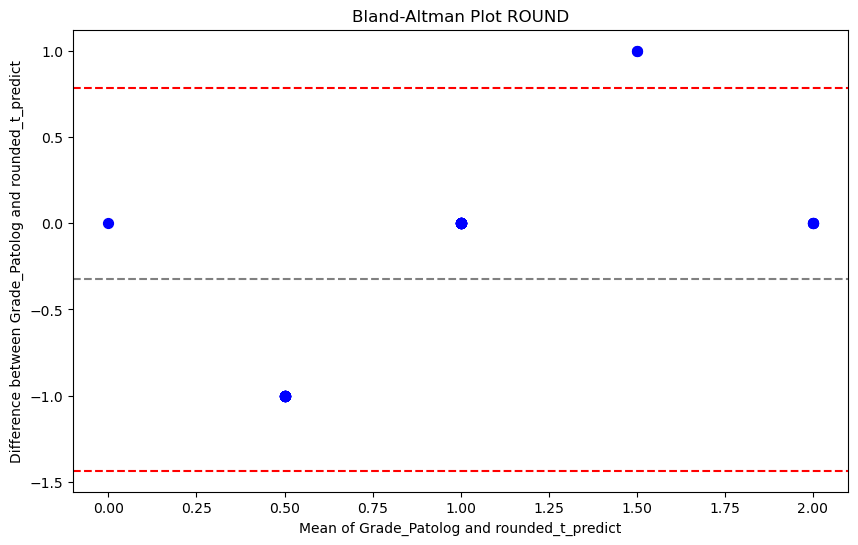

In [1135]:
# Рассчитаем средние и разности
df_1['mean'] = df_1[['Grade_Patolog', 'Grade_roundPredcit']].mean(axis=1)
df_1['diff'] = df_1['Grade_Patolog'] - df_1['Grade_roundPredcit']

mean_diff = df_1['diff'].mean()
std_diff = df_1['diff'].std()

# Построение Bland-Altman Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_1['mean'], df_1['diff'], color='blue', s=50)
plt.axhline(mean_diff, color='gray', linestyle='--')
plt.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--')
plt.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--')

plt.title('Bland-Altman Plot ROUND')
plt.xlabel('Mean of Grade_Patolog and rounded_t_predict')
plt.ylabel('Difference between Grade_Patolog and rounded_t_predict')
plt.show()

In [1165]:
df_1['diff'].value_counts()

diff
-0.366972    1
 0.656250    1
 0.155844    1
 0.611765    1
 0.847458    1
 0.630952    1
 0.714286    1
-0.238095    1
 0.096000    1
 0.314516    1
-0.253333    1
 0.184211    1
-0.221374    1
 0.194969    1
 0.125000    1
-0.192000    1
-0.242647    1
-0.260504    1
-0.313131    1
-0.504065    1
 0.250000    1
 0.333333    1
 0.945205    1
-0.301887    1
 0.428571    1
 0.691589    1
 0.496063    1
 0.655172    1
-0.085106    1
 0.670886    1
 0.826667    1
 1.055556    1
 1.330986    1
 0.278846    1
 0.171171    1
-0.089109    1
-0.048544    1
-0.151163    1
 0.643678    1
-0.247934    1
 0.511811    1
-0.387387    1
-0.176923    1
Name: count, dtype: int64

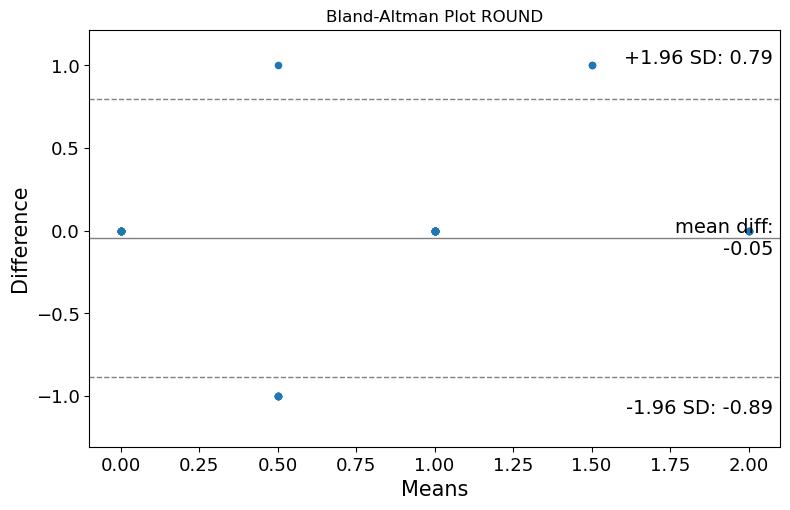

In [1155]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Bland-Altman plot 
f, ax = plt.subplots(1, figsize = (8,5))
sm. graphics.mean_diff_plot (df_1['Grade_Patolog'], df_1['Grade_roundPredcit'], ax = ax)

#display Bland-Altman plot
plt.title('Bland-Altman Plot ROUND')
plt.show() 

In [1180]:
# Бутстрап для оценки статистической значимости
def bootstrap_kappa(data, n_iterations=1000):
    n_size = len(data)
    kappa_values = []
    for i in range(n_iterations):
        sample = data.sample(n_size, replace=True)
        kappa = cohen_kappa_score(sample['Grade_Patolog'], sample['Grade_roundPredcit'])
        kappa_values.append(kappa)
    return kappa_values

# Запуск бутстрапа
np.random.seed(42)
bootstrap_kappas = bootstrap_kappa(df_1)

# Вычисление доверительного интервала и p-value
bootstrap_kappas = np.array(bootstrap_kappas)
ci_lower = np.percentile(bootstrap_kappas, 2.5)
ci_upper = np.percentile(bootstrap_kappas, 97.5)
p_value = np.mean(bootstrap_kappas < 0)  # Проверка против нулевой гипотезы, что kappa <= 0

print(f"95% Confidence Interval for Kappa: [{ci_lower}, {ci_upper}]")
print(f"p-value: {p_value}")

95% Confidence Interval for Kappa: [0.4679695594193979, 0.8723452970297029]
p-value: 0.0


### Корреляция

In [1181]:
# Вычисление корреляции Пирсона

from scipy.stats import pearsonr


correlation, p_value = pearsonr(df['Grade_Patolog'], df['Grade_roundPredcit'])
print(f'Pearson Correlation: {correlation:.4f}')
print(f'P-value: {p_value:.4f}')

Pearson Correlation: 0.7841
P-value: 0.0000


In [1182]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Матрица ошибок
conf_matrix = confusion_matrix(df['Grade_Patolog'], df['Grade_roundPredcit'])
print("Confusion Matrix:\n", conf_matrix)

# Отчет по классификации
print("Classification Report:\n", classification_report(df['Grade_Patolog'], df['Grade_roundPredcit']))

# Точность
accuracy = accuracy_score(df['Grade_Patolog'], df['Grade_roundPredcit'])
print(f'Accuracy: {accuracy:.4f}')

Confusion Matrix:
 [[12  5  0]
 [ 1 19  0]
 [ 0  2  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.73      0.95      0.83        20
           2       1.00      0.67      0.80         6

    accuracy                           0.81        43
   macro avg       0.88      0.77      0.81        43
weighted avg       0.84      0.81      0.81        43

Accuracy: 0.8140


In [1184]:
x=['ab','cd', 'ef'] 
print(list(map(list,x)))

[['a', 'b'], ['c', 'd'], ['e', 'f']]


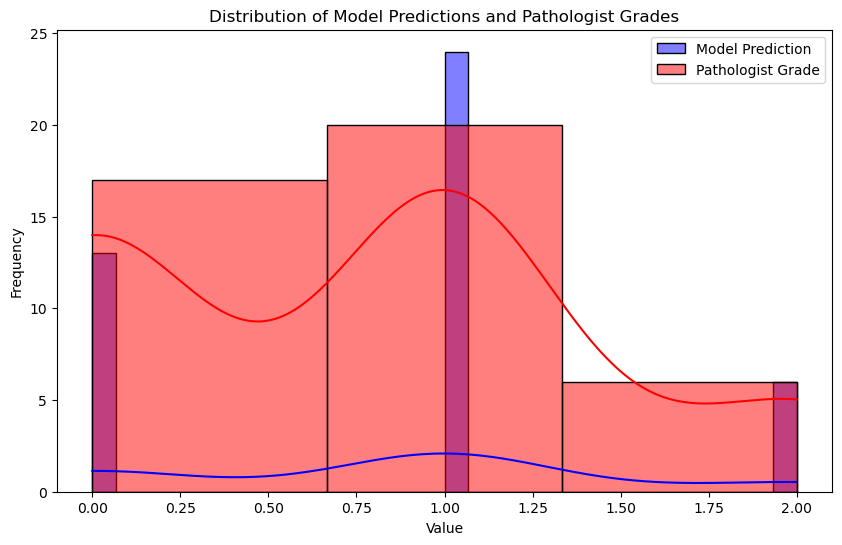

In [860]:
# Гистограммы и KDE-графики
plt.figure(figsize=(10, 6))
sns.histplot(df['Grade_roundPredcit'], kde=True, color='blue', label='Model Prediction', bins=30)
sns.histplot(df['Grade_Patolog'], kde=True, color='red', label='Pathologist Grade', bins=3, alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Model Predictions and Pathologist Grades')
plt.legend()
plt.show()